In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import json
import sys

ModuleNotFoundError: No module named 'pandas'

In [40]:
df_disorder = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t').astype('object')
df_proteins = pd.read_csv('./project_pipeline/data/proteins.tsv', sep='\t').astype('object')
uniprot_unique = df_disorder['uniprot'].unique()
minimum_values = []
for uniprot in uniprot_unique:
    uniprot_df = df_disorder[df_disorder['uniprot'] == uniprot]
    minimum_value = uniprot_df['2_comp'].min()
    minimum_values.append(minimum_value)

df_mins = df_disorder
for i in range(len(df_disorder)):
    if float(df_mins.loc[i, '2_comp']) not in minimum_values:
        df_mins.drop(index=i, inplace=True)

df_copy = df_mins.drop_duplicates(keep='first').reset_index()

def stringtolist(string):
    if ',' in string:
        bounds_str_list = string.split(',')
        bounds_int_list = []
        for bounds in bounds_str_list:
            bounds = bounds.split('-')
            bounds = [int(i) for i in bounds]
            for bound in bounds:
                bounds_int_list.append(bound)

    else:
        bounds_str_list = string.split('-')
        bounds_int_list = [int(i) for i in bounds_str_list]

    return bounds_int_list
 
# function to calculate
# Small result between
# two arrays
def findSmallestDifference(A, B, m, n):
 
    # Sort both arrays
    # using sort function
    A.sort()
    B.sort()
 
    a = 0
    b = 0
 
    # Initialize result as max value
    result = sys.maxsize
 
    # Scan Both Arrays upto
    # sizeof of the Arrays
    while (a < m and b < n):
     
        if (abs(A[a] - B[b]) < result):
            result = abs(A[a] - B[b])
 
        # Move Smaller Value
        if (A[a] < B[b]):
            a += 1
 
        else:
            b += 1
    # return final sma result
    return result
 
# Driver Code

for i in range(len(df_copy)):
    region_1 = df_copy.loc[i, 'region_1']
    region_2 = df_copy.loc[i, 'region_2']
    region_1_bounds = stringtolist(region_1)
    region_2_bounds = stringtolist(region_2)
    len1 = len(region_1_bounds)
    len2 = len(region_2_bounds)

    smallest_dif = findSmallestDifference(region_1_bounds, region_2_bounds, len1, len2)
    df_copy.loc[i, 'smallest_dif'] = smallest_dif

df_copy.to_csv('df_copy.tsv', sep='\t', index=False)

In [41]:
df = pd.read_csv('../autoinhibition_protein_data/df_copy.tsv', sep='\t').astype('object')
df = df.astype({'smallest_dif': 'float'})
df_min = df[['conformation', 'uniprot', 'smallest_dif']]

In [18]:
plt.style.use('ggplot')

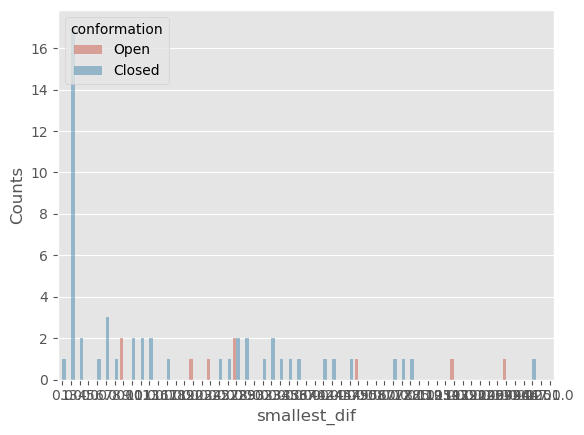

In [45]:
# Make a dataframe with the number of counts of each conformation at each minimum sequence distance
df_min = df_min[['conformation', 'smallest_dif']]
df_min['Counts'] = df_min.groupby(['smallest_dif'])['conformation'].transform('count')

g = sns.barplot(x='smallest_dif', y='Counts', hue='conformation', data=df_min.drop_duplicates(), alpha=0.5)

plt.savefig('./project_pipeline/data/figures/seq_dist_correlation.png', dpi=300, bbox_inches='tight')

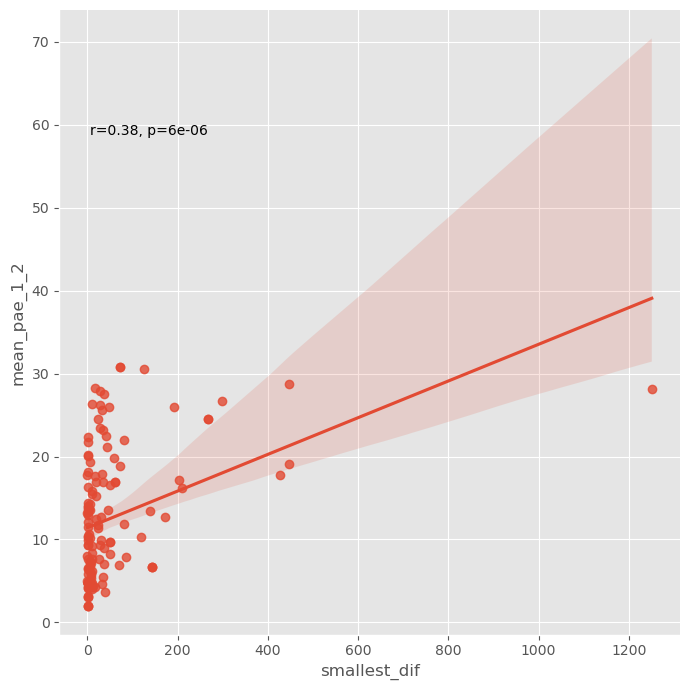

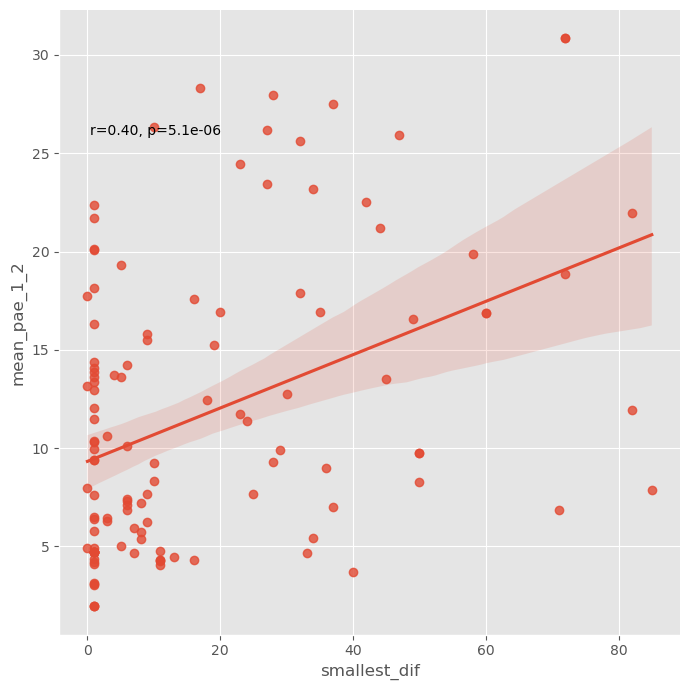

In [43]:
df_num = df[['mean_pae_1_2', 'smallest_dif']].astype('float')
df_no_outlier = df_num[df_num['smallest_dif'] < 100.0]

g = sns.lmplot(x='smallest_dif', y='mean_pae_1_2', data=df_num, height=7, aspect=1)
g2 = sns.lmplot(x='smallest_dif', y='mean_pae_1_2', data=df_no_outlier, height=7, aspect=1)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['smallest_dif'], data['mean_pae_1_2'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g2.map_dataframe(annotate)
